In [1]:
!pip install pyswarms

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 3.1 MB/s eta 0:00:00


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import numpy as np
import pyswarms as ps
from sklearn.model_selection import cross_val_score

In [3]:
df = pd.read_csv('/content/pca_transformed_data_25.csv')

In [4]:
# Split into train(70%) and temp(30%)
df_train, df_temp = train_test_split(df, test_size=0.3, random_state=42, stratify=df['Test Results'])

# Split temp into val(15%) and test(15%)
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=42, stratify=df_temp['Test Results'])

In [5]:
print(f"Original dataframe size: {len(df)}")
print(f"Training set size: {len(df_train)}")
print(f"Validation set size: {len(df_val)}")
print(f"Testing set size: {len(df_test)}")

Original dataframe size: 50000
Training set size: 35000
Validation set size: 7500
Testing set size: 7500


In [6]:
sample_size = min(10000, len(df_train))
df_train_sample = df_train.sample(n=sample_size, random_state=42)

In [7]:
X_train_sample = df_train_sample.drop('Test Results', axis=1).replace({False: 0, True: 1})
y_train_sample = df_train_sample['Test Results']

In [8]:
bounds = (np.array([-1, -4]),  # log10(0.1), log10(1e-4)
          np.array([2, 0]))    # log10(100), log10(1)

In [9]:
def fitness_function(params):
    scores = []
    for particle in params:
        C = 10 ** particle[0]
        gamma = 10 ** particle[1]
        svm = SVC(C=C, gamma=gamma, kernel='rbf')
        # 3-fold CV for speed
        score = cross_val_score(svm, X_train_sample, y_train_sample, cv=3, scoring='accuracy').mean()
        scores.append(1 - score)  # minimize inverted accuracy
    return np.array(scores)

In [10]:
# PSO setup
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
optimizer = ps.single.GlobalBestPSO(n_particles=15, dimensions=2, options=options, bounds=bounds)

In [11]:
# Run PSO optimization (20 iterations)
best_cost, best_pos = optimizer.optimize(fitness_function, iters=20)

2025-05-27 21:23:37,986 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=0.18
2025-05-27 22:10:08,342 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.17990062353565894, best pos: [ 1.84965514 -1.49541584]


In [12]:
X_train = df_train.drop('Test Results', axis=1).replace({False: 0, True: 1})
y_train = df_train['Test Results']

In [13]:
# Train final SVM model on full training data
final_C = 10 ** best_pos[0]
final_gamma = 10 ** best_pos[1]

In [14]:
final_svm = SVC(C=final_C, gamma=final_gamma, kernel='rbf')
final_svm.fit(X_train, y_train)

SVC(C=np.float64(70.73838482273977), gamma=np.float64(0.031958335903777384))

In [15]:
print("Final SVM model trained on full training data.")

Final SVM model trained on full training data.


In [16]:
# Optionally prepare validation and test sets (for later use)
X_val = df_val.drop('Test Results', axis=1).replace({False: 0, True: 1})
y_val = df_val['Test Results']

X_test = df_test.drop('Test Results', axis=1).replace({False: 0, True: 1})
y_test = df_test['Test Results']

In [17]:
#print the accuracy
y_pred = final_svm.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy}")

Validation Accuracy: 0.8236


In [18]:
#Actual Accuracy
y_pred = final_svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy}")

Test Accuracy: 0.8225333333333333


In [19]:
#Accuracy of training
y_pred = final_svm.predict(X_train)
accuracy = accuracy_score(y_train, y_pred)
print(f"Training Accuracy: {accuracy}")

Training Accuracy: 0.8385142857142858


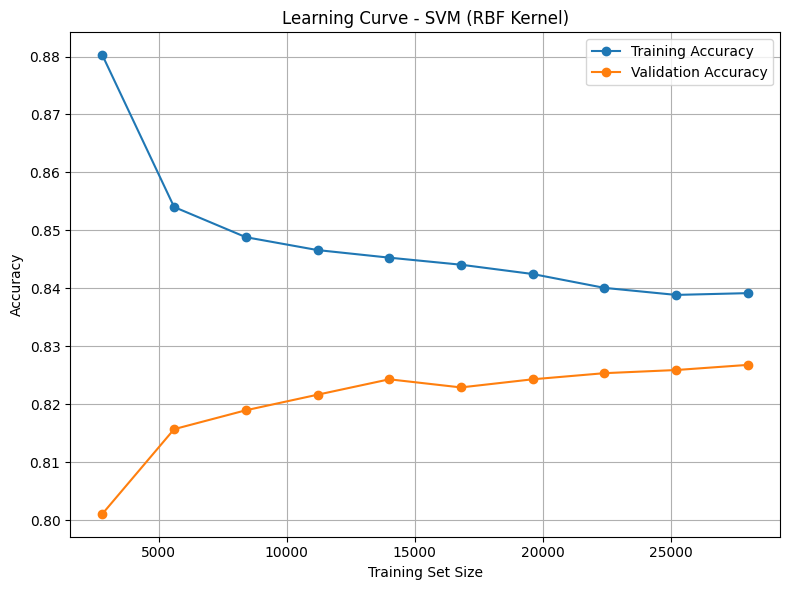

In [20]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

train_sizes, train_scores, test_scores = learning_curve(
    estimator=final_svm,
    X=X_train,
    y=y_train,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    random_state=42
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', label="Training Accuracy")
plt.plot(train_sizes, test_scores_mean, 'o-', label="Validation Accuracy")
plt.title("Learning Curve - SVM (RBF Kernel)")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()


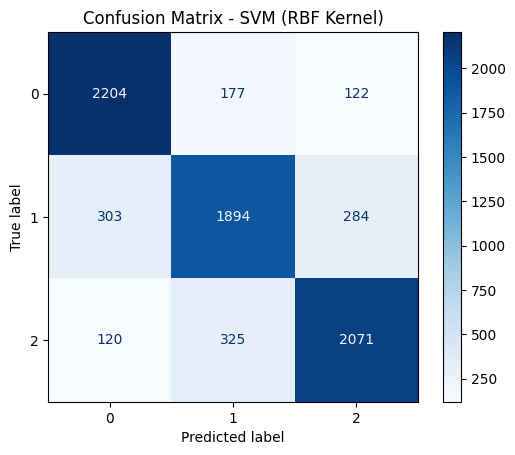

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_svm = final_svm.predict(X_test)
cm_svm = confusion_matrix(y_test, y_pred_svm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_svm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - SVM (RBF Kernel)")
plt.show()